# Driving Data Exploration

The purpose of this notebook is to gain familiarity with the data used to teach the car to drive by itself, just by mimicking/cloning the behavior of a human at the wheel.

### Gathering data

The data that'll be passed to our model is comprised of images recorded by three cameras mounted on the car (left, center and right). These images are accompanied by the following metrics:
 * Steering angle (a negative value means a turn to the left, a zero means no steering and a positive value means a turn to the right).
 * Throttle.
 * Speed.
 * Brake.

For this project we'll be using the data pre-recorded by Udacity (available [here](https://d17h27t6h515a5.cloudfront.net/topher/2016/December/584f6edd_data/data.zip)) for several reasons:
 * Gathering **good** data on the simulator requires a lot of effort.
 * Collecting recovery images is easier said than done (more on this on further sections).
 * Driving the car in a simulator only using a keyboard is **_REALLY_** hard. Using a joystick is almost mandatory. (You can download the simulator [for Linux here](https://d17h27t6h515a5.cloudfront.net/topher/2016/November/5831f0f7_simulator-linux/simulator-linux.zip))

### Exploration:

Let's start our exploration by importing the tools we'll need:

In [1]:
import matplotlib.image as mpimg
import numpy as np
import csv
import matplotlib.pyplot as plt
import matplotlib.colors as c
import cv2
%matplotlib inline

Now, let's define some helper functions (Note that these same functions are defined at **model.py**):

In [2]:
def load_driving_log(path):
    """
    Loads the driving log and stores its data in a list of dicts, where each dict represents a row.
    :param path: Path of the driving log file to load.
    :return: List of dicts.
    """
    with open(path) as csvfile:
        reader = csv.DictReader(csvfile)
        rows = []

        # Apply some minor processing to each field.
        for row in reader:
            # Must strip out extra blank characters from the path of the images.
            row['center'] = row['center'].strip()
            row['left'] = row['left'].strip()
            row['right'] = row['right'].strip()

            # Parse numeric fields into float numbers.
            row['throttle'] = float(row['throttle'])
            row['steering'] = float(row['steering'])
            row['brake'] = float(row['brake'])
            row['speed'] = float(row['speed'])

            rows.append(row)

    return rows


def resize(img, new_shape=(200, 66)):
    """
    Resizes an image. The return image will have size (new_shape[0], new_shape[1])
    """

    return cv2.resize(img, new_shape, interpolation=cv2.INTER_CUBIC)


def apply_random_brightness(img):
    """
    Applies random brightness modification to the input image.
    :param img: Image to be modified.
    :return: Input image with a little brightness perturbation (this means it may be a bit darker or a bit brighter).
    """
    # We must convert to HSV color space in order to successfully apply a random brightness perturbation.
    img_hsv = c.rgb_to_hsv(img)

    # Only alter the H and S channels.
    # The 0.25 is a constant that prevents the image from going completely black.
    img_hsv[:, :, 2] = img_hsv[:, :, 2] * (0.25 + np.random.uniform())

    # We must come back to RGB space.
    return c.hsv_to_rgb(img_hsv)


def normalize(img):
    """
    Takes an image and normalizes each of its pixel values by dividing their value by 255. Hence, each value will range
    between 0 and 1.
    :param img: Image to be normalized.
    :return: Input image normalized so its pixel values belong to the interval [0, 1]
    """
    return img.astype("float") / 255


def crop_car_and_sky(img):
    """
    Takes out the portion of the image where the hood is visible, as well as a fair amount of the sky and other
    landscape elements.
    :param img: Image to be modified.
    :return: Input image without the segments where (most of) the sky and car's hood were visible.
    """
    return img[45:135, :, :]


def horizontal_flip(img):
    """
    Takes an image and flips it around the Y axis.
    :param img: Image to be flipped.
    :return: Input image horizontally flipped.
    """
    return cv2.flip(img, 1)


def pre_process(img, new_shape=(200, 66)):
    """
    Takes an image and pre process it by applying the following transformations:
        1. Cropping.
        2. Resizing.
        3. Normalization.
    :param img: Image to be processed.
    :param new_shape: Shape of the output image.
    :return: Input imaged after the processing steps described above.
    """
    return normalize(resize(crop_car_and_sky(img), new_shape))

Let's load the data:

In [3]:
rows = load_driving_log('./small_sample_data/driving_log.csv')
print('Sample row:', rows[0])
print('Number of images per camera:', len(rows))
print('Total number of images:', 3 * len(rows))
print('Number of left turns:', sum(1 for r in rows if r['steering'] < 0))
print('Number of right turns:', sum(1 for r in rows if r['steering'] > 0))
print('Number of frames with no turns', sum(1 for r in rows if r['steering'] ==0))

Sample row: {'right': 'IMG/right_2016_12_01_13_30_48_287.jpg', 'center': 'IMG/center_2016_12_01_13_30_48_287.jpg', 'throttle': 0.0, 'brake': 0.0, 'speed': 22.14829, 'steering': 0.0, 'left': 'IMG/left_2016_12_01_13_30_48_287.jpg'}
Number of images per camera: 8036
Total number of images: 24108
Number of left turns: 1775
Number of right turns: 1900
Number of frames with no turns 4361


So, we see that roughly half of the data corresponds to frames with no turn at all, and among those images that correspond to frames where the car is steering, there are more turns to the right.

This indicates a bias towards right turns and straight driving. We need to augment our data in order to avoid this. But first, let's visualize some of these images:

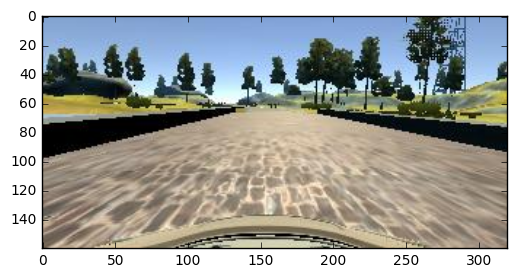

In [4]:
# Center
img = mpimg.imread("./small_sample_data/" + rows[0]['center'])
plt.imshow(img)

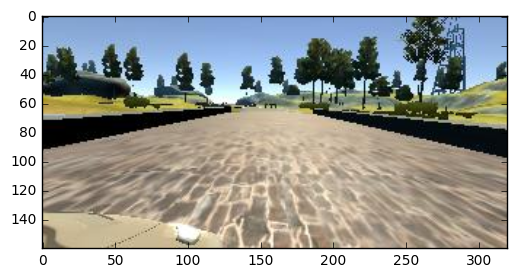

In [5]:
# Right
img = mpimg.imread("./small_sample_data/" + rows[0]['right'])
plt.imshow(img)

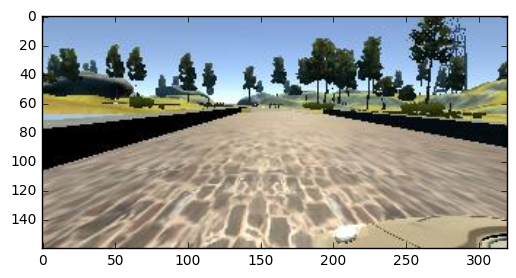

In [6]:
# Left
img = mpimg.imread("./small_sample_data/" + rows[0]['left'])
plt.imshow(img)

We notice that the hood of the car is visible. We don't want this. Also, half of the picture is occupied by scenery that isn't relevant to the problem at hand. We'll crop out this segments. Let's see what we get:

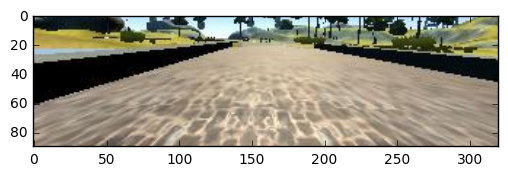

In [10]:
plt.imshow(crop_car_and_sky(img))

Much better, isn't it? But... We still have a problem... Our data is really unbalanced. So, we'll need to fix this situation by artificially extending our dataset. In order to do this we'll apply two techniques:
 * Flipping images horizontally.
 * Altering the brightness of the image.

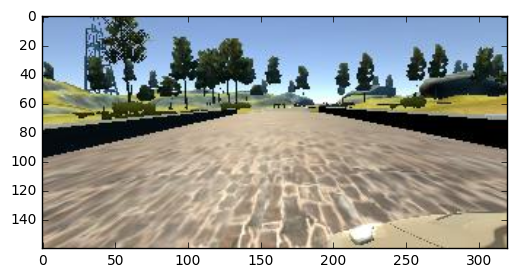

In [8]:
# Flipping:
right = mpimg.imread("./small_sample_data/" + rows[0]['right'])
plt.imshow(horizontal_flip(right))

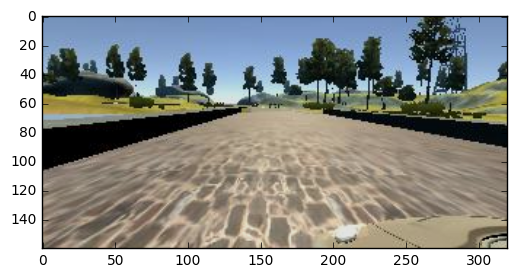

In [9]:
# Brightness
img = mpimg.imread("./small_sample_data/" + rows[0]['left'])
plt.imshow(normalize(apply_random_brightness(img)))

### Conclusions

* Our data is biased towards right turns and straight driving.
* We need to augment our data set by applying random (small) brightness perturbations and horizontal flippings.
* In order to train our model for recovering, we need to make use of the left and right cameras.
* In order to reduce the dimensionality of the images we can crop the hood of the car and the top of the image, just above the horizon, so our model can focus mostly on the road.